<h1>Лабораторная работа №5: Методы,
основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.
</h1>

In [22]:
# загрузка пакетов: инструменты -------------------------------------------- # работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# загрузка файлов по URL
import urllib
# проверка существования файла на диске
from pathlib import Path
# для форматирования результатов с помощью Markdown
from IPython.display import Markdown, display
# перекодировка категориальных переменных
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder # хи-квадрат тест на независимость по таблице сопряжённости
from scipy.stats import chi2_contingency
# для таймера
import time
# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets
# загрузка пакетов: модели ------------------------------------------------- # дерево классификации
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
# перекрёстная проверка и метод проверочной выборки
from sklearn.model_selection import cross_val_score, train_test_split # для перекрёстной проверки и сеточного поиска
from sklearn.model_selection import KFold, GridSearchCV
# бэггинг
from sklearn.ensemble import BaggingClassifier
# случайный лес
from sklearn.ensemble import RandomForestClassifier
# бустинг
from sklearn.ensemble import GradientBoostingClassifier # сводка по точности классификации
from sklearn.metrics import classification_report

In [23]:
# константы
# ядро для генератора случайных чисел
my_seed = 11
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [24]:
# функция форматирования результатов с использованием Markdown
def printmd(string):
  display(Markdown(string))
  # функции для попарной конкатенации элементов двух списков
concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)
  # функция, которая строит график важности признаков в модели случайного леса
  # источник: https://www.analyseup.com/learn-python-for-data-science/python-rand
def plot_feature_importance(importance, names, model_type) :
      #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names']) #Add chart labels
  plt.title('Важность признаков в модели: ' + model_type)
  plt.xlabel('Важность признака')
  plt.ylabel('')

In [43]:
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/winequality-white_for_lab.csv'

DF_all = pd.read_csv(fileURL)

DF_all1 = DF_all[['fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides','free_sulfur_dioxide',
                'total_sulfur_dioxide','density','pH','sulphates','alcohol','Y']]

# наблюдения для моделирования
DF = DF_all1.sample(frac = 0.85, random_state = my_seed)
# отложенные наблюдения
DF_predict = DF_all1.drop(DF.index)


In [26]:
DF_all1.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
Y                         int64
dtype: object

**<h3>Предварительный анализ данных</h3>**

In [27]:
# считаем частоты по столбцам, учитывая пропуски
for col in DF.columns:
  freq_col = DF[col].value_counts(dropna=False)
  str_freqs = np.around(freq_col / sum(freq_col), 3).astype(str)
  str_names = freq_col.index.values.astype(str)
  # для вывода в html
  # printmd('**' + col + '**</br>' +
  # '</br>'.join(list(map(concat_func_md, str_names, str_freqs)))) # для сохранения в pdf
  print('\n', col, '\n','\n'.join(list(map(concat_func, str_names, str_freqs))))


 fixed_acidity 
 6.8    0.064
6.6    0.06
6.4    0.058
6.7    0.049
6.9    0.048
7.0    0.047
6.5    0.043
7.2    0.043
7.1    0.042
7.4    0.04
6.2    0.039
6.0    0.038
6.3    0.037
7.3    0.035
7.6    0.032
6.1    0.031
7.5    0.025
5.8    0.025
5.9    0.02
7.7    0.019
7.8    0.018
5.7    0.018
8.0    0.015
7.9    0.015
5.6    0.013
8.1    0.011
8.2    0.011
8.3    0.011
8.4    0.007
5.5    0.006
8.5    0.006
5.4    0.006
5.3    0.006
5.2    0.006
8.6    0.005
9.2    0.005
5.0    0.005
5.1    0.004
9.0    0.004
8.8    0.004
8.9    0.004
8.7    0.003
9.4    0.002
4.8    0.002
9.8    0.002
4.9    0.002
9.1    0.001
4.7    0.001
9.6    0.001
9.3    0.001
4.4    0.001
10.0    0.001
9.7    0.0
10.7    0.0
6.15    0.0
4.2    0.0
10.3    0.0
9.5    0.0
3.9    0.0
6.45    0.0
7.15    0.0
4.6    0.0
11.8    0.0
3.8    0.0
4.5    0.0
10.2    0.0
14.2    0.0
9.9    0.0

 volatile_acidity 
 0.28    0.055
0.24    0.051
0.26    0.05
0.22    0.047
0.25    0.045
0.2    0.044
0.23    0.044
0.27   

In [28]:
str_freqs.astype(str)

Y
1    0.663
0    0.337
Name: count, dtype: object

In [29]:
# считаем пропуски в столбцах, выводим ненулевые значения
nas = DF.isna().sum()
nas = np.around(nas / DF.shape[0], 3)
nas[nas > 0]

Series([], dtype: float64)

Пропусков нет

Рассмотрим ниже распределение предикторов внутри классов по зависимой переменной с помошью ХИ-квадрат. Нулевая гипотеза теста: распределение долей в таблице сопряжённости случайно, т.е. два показателя независимы друг от друга.
Проведём тест для всех пар "объясняющая переменная" – "зависимая переменная" и выведем те пары, для которых соответствующее критерию p-значение больше 0.05 (т.е. нулевая гипотеза принимается, переменные независимы)

In [37]:
for col in DF.columns[:12]:
    con_tab = pd.crosstab(DF[col], DF['Y'])
    c, p, dof, expected = chi2_contingency(con_tab)

    if p > 0.05:
        print(col, 'и Y','\nH_0: переменные распределены независимо друг от друга', '\nP-значение:', np.around(p, 4))

**<h3>Дерево на всех признаках</h3>**

In [56]:
# выращиваем дерево на всех объясняющих
X = DF.drop(['Y'], axis=1)
y = DF['Y']
# классификатор

cls_one_tree = DecisionTreeClassifier(criterion='entropy', random_state=my_seed)
tree_full = cls_one_tree.fit(X, y)
# выводим количество листьев (количество узлов)
tree_full.get_n_leaves()

566

In [57]:
# глубина дерева: количество узлов от корня до листа # в самой длинной ветви
tree_full.get_depth()

21

Очевидно, дерево получилось слишком большое для отображения в текстовом формате. Графическая визуализация тоже не поможет в данном случае. Посчитаем показатели точности с перекрёстной проверкой

In [58]:
# будем сохранять точность моделей в один массив:
score = list()
score_models = list()
# считаем точность с перекрёстной проверкой, показатель Acc
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5, scoring='accuracy')
# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')
print('Acc с перекрёстной проверкой','\nдля модели', score_models[0], ':', score[0])

Acc с перекрёстной проверкой 
для модели one_tree : 0.773


**<h3>Дерево с обрезкой ветвей</h3>**

In [59]:
# рассчитываем параметры alpha для эффективных вариантов обрезки ветвей
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 316
Энтропия листьев для первых 5 значений alpha: [0.         0.00093686 0.00141728 0.0018977  0.00237813]


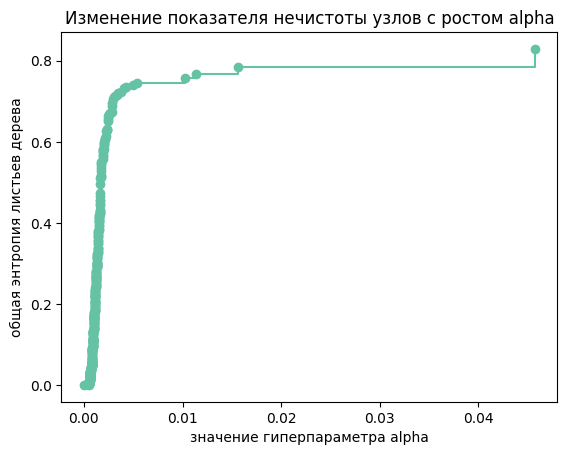

In [61]:
# изображаем на графике
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [63]:
# обучающая и тестовая выборки, чтобы сэкономить время
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=my_seed)
# модели
clfs = list()
# таймер
tic = time.perf_counter()
# цикл по значениям alpha
for ccp_alpha in ccp_alphas:
  clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
  clf.fit(X_train, y_train)
  clfs.append(clf)
# таймер
toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")

Расчёты по обрезке дерева заняли 10.74 секунд


In [64]:
# извлекаем характеристики глубины и точности
# таймер
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
# таймер
toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 1.50 секунд


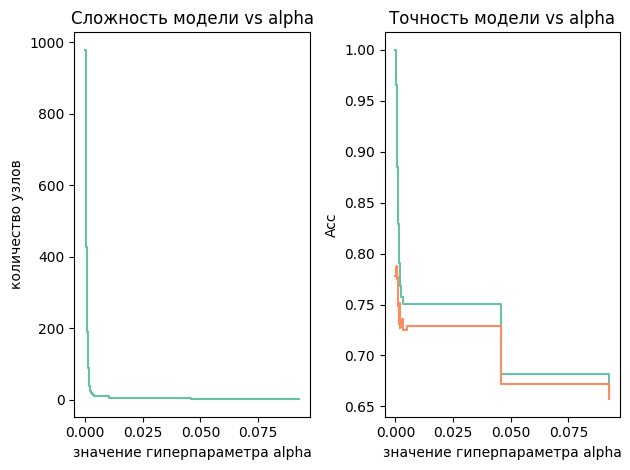

In [65]:
# изображаем на графике
fig, ax = plt.subplots(1, 2)
# график глубины дерева
ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")
# график точности
ax[1].plot(ccp_alphas, train_scores, marker=',', label='train', drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test', drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели vs alpha")
fig.tight_layout()

Находим оптимальный размер дерева по максимуму на тестовой выборке

In [87]:
# оптимальное количество узлов
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

# считаем точность с перекрёстной проверкой, показатель Acc
if len(clfs)<opt_nodes_num:
  estimator=clfs[-1]
else:
  estimator=clfs[opt_nodes_num]
cv = cross_val_score(estimator=estimator, X=X, y=y, cv=5, scoring='accuracy')
# записываем точность
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')
print('Оптимальное количество узлов:', opt_nodes_num,
'\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3), '\n\nAcc с перекрёстной проверкой',
'\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 387 
соответствующая Acc на тестовой: 0.788 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.663


In [91]:
# находим деревья с количеством листьев меньше 20
[i for i in node_counts if i < 20]

[19, 19, 19, 19, 19, 15, 15, 13, 13, 11, 11, 11, 9, 9, 5, 5, 5, 3, 1]

Количество узлов: 11 
Точность дерева на тестовой: 0.725


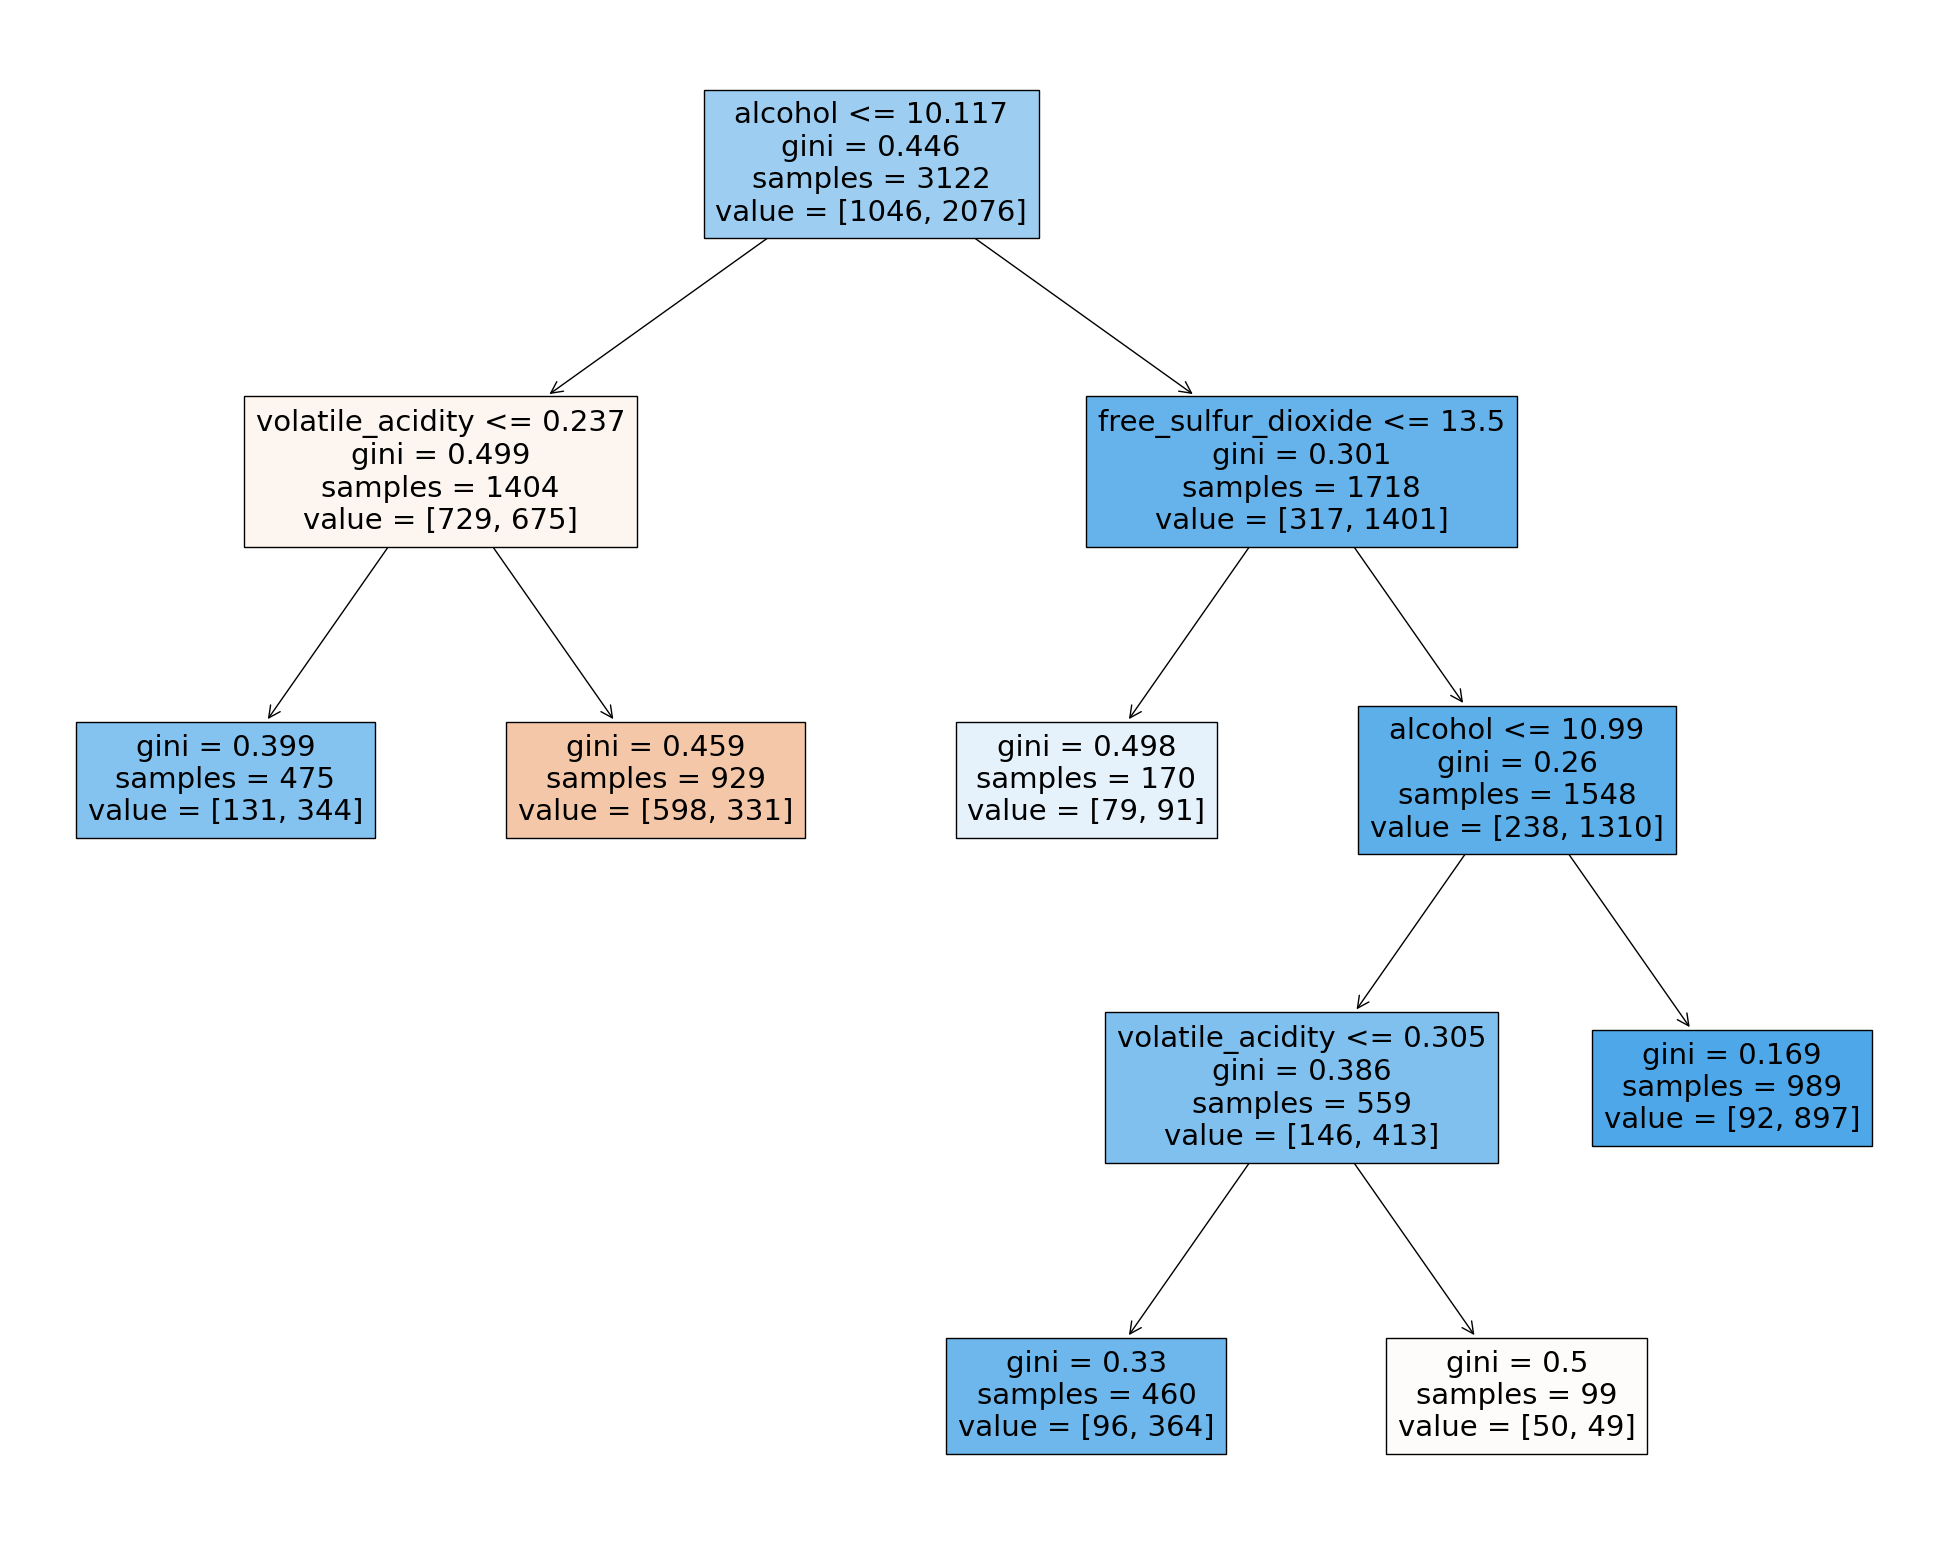

In [92]:
# визуализация на схеме НА ПРИМЕРЕ МАЛЕНЬКОГО ДЕРЕВА
nodes_num = 11
print('Количество узлов:', nodes_num,
'\nТочность дерева на тестовой:', np.around(test_scores[node_counts.index(nodes_num)], 3))
fig = plt.figure(figsize=(25,20))
_ = plot_tree(clfs[node_counts.index(nodes_num)], filled=True,
feature_names=X.columns)

In [93]:
# визуализируем дерево в виде текстовой схемы
viz = export_text(clfs[node_counts.index(nodes_num)], feature_names=list(X.columns))
print(viz)

|--- alcohol <= 10.12
|   |--- volatile_acidity <= 0.24
|   |   |--- class: 1
|   |--- volatile_acidity >  0.24
|   |   |--- class: 0
|--- alcohol >  10.12
|   |--- free_sulfur_dioxide <= 13.50
|   |   |--- class: 1
|   |--- free_sulfur_dioxide >  13.50
|   |   |--- alcohol <= 10.99
|   |   |   |--- volatile_acidity <= 0.31
|   |   |   |   |--- class: 1
|   |   |   |--- volatile_acidity >  0.31
|   |   |   |   |--- class: 0
|   |   |--- alcohol >  10.99
|   |   |   |--- class: 1



<h3>Случайный лес</h3>

In [94]:
# сколько столбцов в обучающих данных (p)
X_m = X.shape[1]
# возьмём значения для m: p, p/2, sqrt(p) и log2(p)
ms = np.around([X_m, X_m / 2, np.sqrt(X_m), np.log2(X_m)]).astype(int)
ms

array([11,  6,  3,  3])

In [95]:
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)

# настроим параметры случайного леса с помощью сеточного поиска
param_grid = {'n_estimators' : [10, 20, 30, 40, 50], 'max_features' : ms}
# таймер
tic = time.perf_counter()
clf = GridSearchCV(RandomForestClassifier(DecisionTreeClassifier()),
param_grid, scoring='accuracy', cv=kfold)
random_forest = clf.fit(X, y)
# таймер
toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')

Сеточный поиск занял 41.40 секунд


In [96]:
# точность лучшей модели
np.around(random_forest.best_score_, 3)

0.829

In [97]:
# количество деревьев у лучшей модели
random_forest.best_estimator_.get_params()['n_estimators']

50

In [98]:
# количество объясняющих у лучшей модели
random_forest.best_estimator_.get_params()['max_features']

6

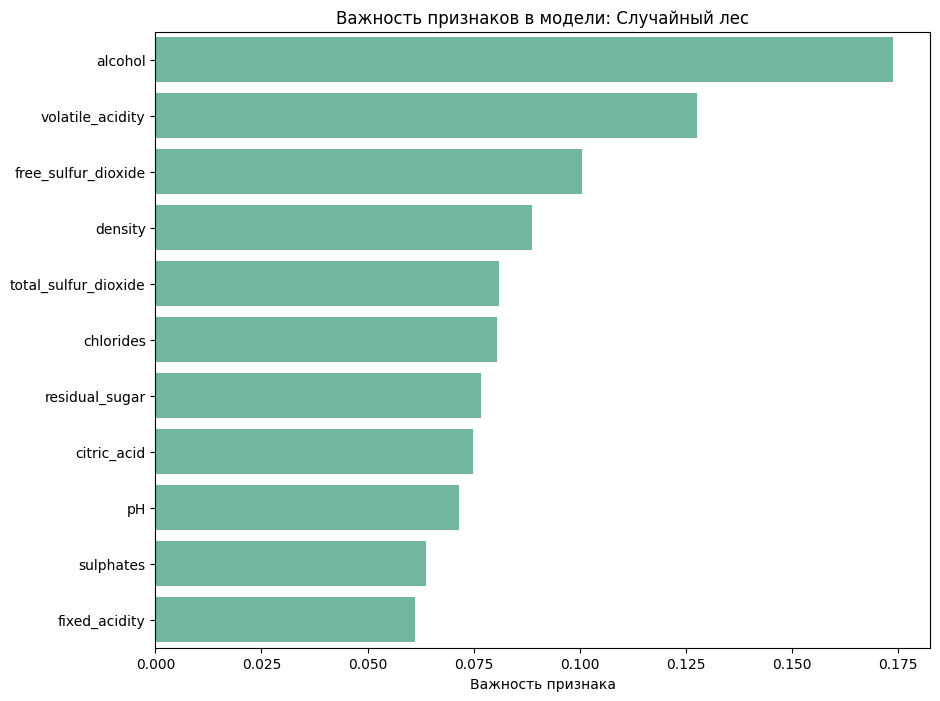

In [99]:
# рисуем график относительной важности каждого признака
plot_feature_importance(random_forest.best_estimator_.feature_importances_, X.columns, 'Случайный лес')

In [108]:
# записываем точность
score.append(np.around(random_forest.best_score_, 3))
score_models.append('random_forest_GS')
print('Acc с перекрёстной проверкой', '\nдля модели', score_models[2], ':', score[2])

Acc с перекрёстной проверкой 
для модели random_forest_GS : 0.829


**<h3>Прогноз на отложенные наблюдения по лучшей модели</h3>**

In [109]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.773
1,pruned_tree,0.663
2,random_forest_GS,0.829
3,random_forest_GS,0.829
4,random_forest_GS,0.829
5,random_forest_GS,0.829
6,random_forest_GS,0.829
7,random_forest_GS,0.829
8,random_forest_GS,0.829
9,random_forest_GS,0.829


Все модели показывают высокую точность по показателю Acc, но наиболее точной
оказывается модель случайного леса. Сделаем прогноз на отложенные наблюдения

In [112]:
# данные для прогноза
X_pred = DF_predict.drop(['Y'], axis=1)
# строим прогноз
y_hat = random_forest.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict['Y'], y_hat))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       237
           1       0.87      0.92      0.89       498

    accuracy                           0.85       735
   macro avg       0.84      0.81      0.82       735
weighted avg       0.85      0.85      0.85       735

